In [ ]:
x_train = train[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
y1_train = train['중식계']
y2_train = train['석식계']

x_test = test[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
%matplotlib inline
plt.rc('font',family='Malgun Gothic')

In [2]:
# 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# 주어진 데이터 탐색 및 전처리

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가자수          50 non-null     int64  
 4   본사출장자수          50 non-null     int64  
 5   본사시간외근무명령서승인건수  50 non-null     int64  
 6   현본사소속재택근무자수     50 non-null     float64
 7   조식메뉴            50 non-null     object 
 8   중식메뉴            50 non-null     object 
 9   석식메뉴            50 non-null     object 
dtypes: float64(1), int64(4), object(5)
memory usage: 4.0+ KB


In [5]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [6]:
train['요일'] = train['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})
test['요일'] = test['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

In [7]:
train["년"] = pd.DatetimeIndex(train["일자"]).year
train["월"] = pd.DatetimeIndex(train["일자"]).month
train["일"] = pd.DatetimeIndex(train["일자"]).day
test["월"] = pd.DatetimeIndex(test["일자"]).month
test["일"] = pd.DatetimeIndex(test["일자"]).day

In [8]:
train["식사가능인원"] = train["본사정원수"] - train["본사휴가자수"] - train["현본사소속재택근무자수"]
# train["중식식사비율"] = (train["중식계"] / train["식사가능인원"])*100
# train["석식식사비율"] = (train["석식계"] / train["식사가능인원"])*100

test["식사가능인원"] = test["본사정원수"] - test["본사휴가자수"] - test["현본사소속재택근무자수"]
# test["중식계"] = train["중식계"]
# test["석식계"] = train["석식계"]
# test["중식식사비율"] = (test["중식계"] / test["식사가능인원"])*100
# test["석식식사비율"] = (test["석식계"] / test["식사가능인원"])*100

- 비율은 큰 의미가 없음 그래프를 통해서도 알수 있지만 필요없는 속성값
- test 파일에 필요한 값으로 들어가지 않는다! (train은 0~9까지라면 test는 0, 4, 7, 3, 이런 순서로 되어있다.)

In [155]:
train.drop(["일자", "조식메뉴", "중식메뉴", "석식메뉴"], axis=1, inplace=False)

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,년,월,일,식사가능인원
0,0,2601,50,150,238,0.0,1039.0,331.0,2016,2,1,2551.0
1,1,2601,50,173,319,0.0,867.0,560.0,2016,2,2,2551.0
2,2,2601,56,180,111,0.0,1017.0,573.0,2016,2,3,2545.0
3,3,2601,104,220,355,0.0,978.0,525.0,2016,2,4,2497.0
4,4,2601,278,181,34,0.0,925.0,330.0,2016,2,5,2323.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2,2983,75,198,4,391.0,1093.0,421.0,2021,1,20,2517.0
1201,3,2983,92,231,462,351.0,832.0,353.0,2021,1,21,2540.0
1202,4,2983,255,248,1,303.0,579.0,217.0,2021,1,22,2425.0
1203,0,2983,107,153,616,327.0,1145.0,502.0,2021,1,25,2549.0


In [156]:
year_mean = train.groupby("년").mean()[["중식계", "석식계", "현본사소속재택근무자수", "본사시간외근무명령서승인건수"]]

In [157]:
year_mean

,중식계,석식계,현본사소속재택근무자수,본사시간외근무명령서승인건수
년,,,,
2016,932.792952,519.418502,0.000000,229.013216
2017,897.614754,457.049180,0.000000,236.782787
2018,882.903766,463.539749,0.000000,239.732218
2019,850.512195,445.386179,0.000000,307.626016
2020,882.267241,430.668103,198.836207,353.995690
2021,1009.705882,396.588235,370.294118,320.647059


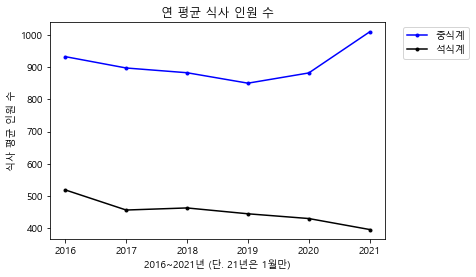

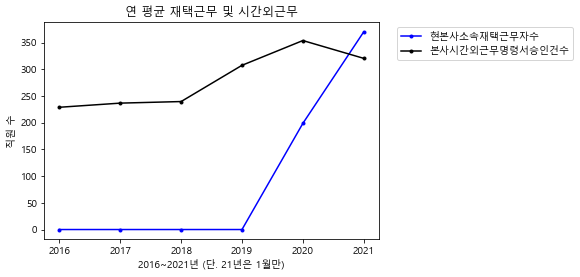

In [158]:
x = ["2016", "2017", "2018", "2019", "2020", "2021"]

plt.subplots()
plt.plot(x, year_mean["중식계"], marker='.', color='blue', label="중식계")
plt.plot(x, year_mean["석식계"], marker='.', color='black', label="석식계")
plt.xlabel("2016~2021년 (단. 21년은 1월만)")
plt.ylabel("식사 평균 인원 수")
plt.title("연 평균 식사 인원 수")
plt.legend(bbox_to_anchor=(1.04, 1))

plt.subplots()
plt.plot(x, year_mean["현본사소속재택근무자수"], marker='.', color='blue', label="현본사소속재택근무자수")
plt.plot(x, year_mean["본사시간외근무명령서승인건수"], marker='.', color='black', label="본사시간외근무명령서승인건수")
plt.xlabel("2016~2021년 (단. 21년은 1월만)")
plt.ylabel("직원 수")
plt.title("연 평균 재택근무 및 시간외근무")
plt.legend(bbox_to_anchor=(1.04, 1))

plt.show()

In [176]:
month_mean = train.groupby("월").mean()[["중식계", "석식계"]]

In [177]:
month_mean

,중식계,석식계
월,,
1,934.247525,424.564356
2,989.623656,514.860215
3,953.607477,530.700935
4,883.621359,480.825243
5,869.787879,458.131313
6,863.311111,460.355556
7,848.736364,437.300000
8,854.785047,459.485981
9,907.148936,463.617021


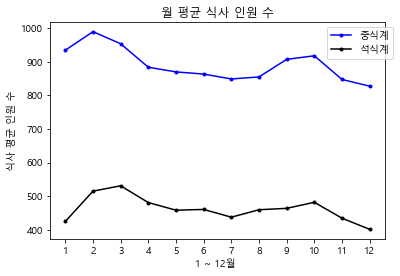

In [178]:
x = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

plt.subplots()
plt.plot(x, month_mean["중식계"], marker='.', color='blue', label="중식계")
plt.plot(x, month_mean["석식계"], marker='.', color='black', label="석식계")
plt.xlabel("1 ~ 12월 ")
plt.ylabel("식사 평균 인원 수")
plt.title("월 평균 식사 인원 수")
plt.legend(bbox_to_anchor=(1.04, 1))

plt.show()

In [179]:
week_mean = train.groupby("요일").mean()[["중식계", "석식계"]]

In [180]:
week_mean

,중식계,석식계
요일,,
0,1144.331950,538.933610
1,925.620833,520.129167
2,905.213389,363.615063
3,823.991803,480.401639
4,653.609959,404.979253


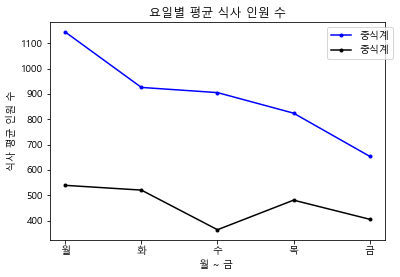

In [182]:
x = ["월", "화", "수", "목", "금"]
plt.subplots()
plt.plot(x, week_mean["중식계"], marker='.', color='blue', label="중식계")
plt.plot(x, week_mean["석식계"], marker='.', color='black', label="중식계")
plt.xlabel("월 ~ 금 ")
plt.ylabel("식사 평균 인원 수")
plt.title("요일별 평균 식사 인원 수")
plt.legend(bbox_to_anchor=(1.04, 1))

plt.show()

In [183]:
employee_week = train.groupby("요일").mean()[["본사정원수", "식사가능인원"]]

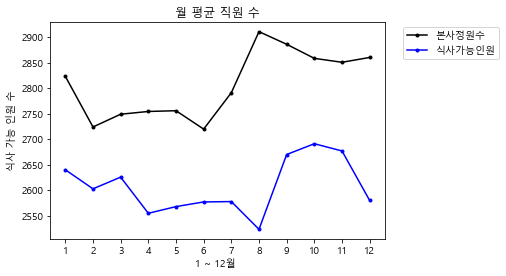

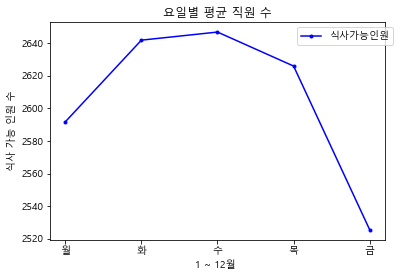

In [184]:
x1 = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
plt.subplots()
plt.plot(x1, employee_month["본사정원수"], marker='.', color='black', label="본사정원수")
plt.plot(x1, employee_month["식사가능인원"], marker='.', color='blue', label="식사가능인원")
plt.xlabel("1 ~ 12월 ")
plt.ylabel("식사 가능 인원 수")
plt.title("월 평균 직원 수")
plt.legend(bbox_to_anchor=(1.04, 1))

x2 = ["월", "화", "수", "목", "금"]
plt.subplots()
plt.plot(x2, employee_week["식사가능인원"], marker='.', color='blue', label="식사가능인원")
plt.xlabel("1 ~ 12월 ")
plt.ylabel("식사 가능 인원 수")
plt.title("요일별 평균 직원 수")
plt.legend(bbox_to_anchor=(1.04, 1))

plt.show()

# 메뉴 데이터 탐색 및 전처리

In [185]:
bistro_train = train[['석식메뉴', '중식메뉴', "조식메뉴"]]
bistro_test = test[['석식메뉴', '중식메뉴', "조식메뉴"]]

In [186]:
lunch_train = []
for i, feature in enumerate(bistro_train["중식메뉴"]):
    a = re.sub("\(.*?\)", "", feature).strip(" ")
    a = re.sub("  ", " ", a)
    lunch_train.append(re.split(" ", a))

In [187]:
lunch_test = []
for i, feature in enumerate(bistro_test["중식메뉴"]):
    a = re.sub("\(.*?\)", "", feature).strip(" ")
    a = re.sub("  ", " ", a)
    lunch_test.append(re.split(" ", a))

In [188]:
dinner_train = []
for i, feature in enumerate(bistro_train["석식메뉴"]):
    a = re.sub("\(.*?\)", "", feature).strip(" ")
    a = re.sub("  ", " ", a)
    dinner_train.append(re.split(" ", a))
dinner_train[19:21]

[['멸치주먹밥', '우동', '떡볶이', '군고구마', '단무지', '포기김치'],
 ['쌀밥/잡곡밥', '오징어국', '미트볼조림', '옥수수전', '부추생채', '포기김치']]

In [189]:
dinner_test = []
for i, feature in enumerate(bistro_test["석식메뉴"]):
    a = re.sub("\(.*?\)", "", feature).strip(" ")
    a = re.sub("  ", " ", a)
    dinner_test.append(re.split(" ", a))
dinner_test[19:21]

[['흑미밥', '계란파국', '쭈꾸미불고기', '모둠채소전*장', '씨앗콩자반', '포기김치'],
 ['흑미밥', '스팸김치찌개', '삼치구이*와사비장', '브로콜리깨소스무침', '연근조림', '포기김치']]

In [190]:
import pandas as pd

col = ["lunch_rice_train", "lunch_soup_train", "lunch_main1_train", "lunch_main2_train", "lunch_main3_train", 
       "lunch_dessert_train", "lunch_Sd1_train", "lunch_Sd2_train"]
lunch_menu_train = pd.DataFrame(lunch_train, columns=col)
lunch_menu_train.fillna("없음", inplace=True)

In [191]:
import pandas as pd

col = ["lunch_rice_test", "lunch_soup_test", "lunch_main1_test", "lunch_main2_test", "lunch_main3_test", 
       "lunch_dessert_test", "lunch_Sd1_test"]
lunch_menu_test = pd.DataFrame(lunch_test, columns=col)
lunch_menu_test.fillna("없음", inplace=True)

In [192]:
import pandas as pd

col = ["dinner_rice_train", "dinner_soup_train", "dinner_main1_train", "dinner_main2_train", "dinner_main3_train", 
       "dinner_dessert_train", "dinner_Sd1_train", "dinner_Sd2_train"]
dinner_menu_train = pd.DataFrame(dinner_train, columns=col)
dinner_menu_train.fillna("없음", inplace=True)

In [193]:
import pandas as pd

col = ["dinner_rice_test", "dinner_soup_test", "dinner_main1_test", "dinner_main2_test", "dinner_main3_test", 
       "dinner_dessert_test", "dinner_Sd1_test"]
dinner_menu_test = pd.DataFrame(dinner_test, columns=col)
dinner_menu_test.fillna("없음", inplace=True)

In [194]:
lrtc =[]
for i in lunch_menu_train["lunch_rice_train"]:
    lrtc.append(i.split("/"))
    
lrtec =[]
for i in lunch_menu_test["lunch_rice_test"]:
    lrtec.append(i.split("/"))
    
drtc =[]
for i in dinner_menu_train["dinner_rice_train"]:
    drtc.append(i.split("/"))
    
drtec =[]
for i in dinner_menu_test["dinner_rice_test"]:
    drtec.append(i.split("/"))

In [195]:
lunch_rice_train_cnt =[]
lunch_rice_test_cnt =[]
dinner_rice_train_cnt =[]
dinner_rice_test_cnt =[]

In [196]:
for i in range(len(lrtc)):
    if len(lrtc[i]) == 1:
        lunch_rice_train_cnt.append(1)
    elif len(lrtc[i]) == 2:
        lunch_rice_train_cnt.append(2)
    elif len(lrtc[i]) == 3:
        lunch_rice_train_cnt.append(3)
        
for i in range(len(lrtec)):
    if len(lrtec[i]) == 1:
        lunch_rice_test_cnt.append(1)
    elif len(lrtec[i]) == 2:
        lunch_rice_test_cnt.append(2)
    elif len(lrtec[i]) == 3:
        lunch_rice_test_cnt.append(3)

for i in range(len(drtc)):
    if len(drtc[i]) == 1:
        dinner_rice_train_cnt.append(1)
    elif len(drtc[i]) == 2:
        dinner_rice_train_cnt.append(2)
    elif len(drtc[i]) == 3:
        dinner_rice_train_cnt.append(3)

for i in range(len(drtec)):
    if len(drtec[i]) == 1:
        dinner_rice_test_cnt.append(1)
    elif len(drtec[i]) == 2:
        dinner_rice_test_cnt.append(2)
    elif len(drtec[i]) == 3:
        dinner_rice_test_cnt.append(3)

In [197]:
lunch_rice_train = []
lunch_rice_test = []
dinner_rice_train = []
dinner_rice_test = []

In [198]:
for i in lunch_menu_train["lunch_rice_train"]:
    if re.search("볶음", i):
        lunch_rice_train.append("볶음밥")
    elif re.search("카레", i):
        lunch_rice_train.append("카레밥")
    elif re.search("장밥", i):
        lunch_rice_train.append("짜장밥")
    elif re.search("특식", i):
        lunch_rice_train.append("찹쌀밥")
    elif re.search("곤드레", i):
        lunch_rice_train.append("곤드레")
    elif re.search("현미밥", i):
        lunch_rice_train.append("잡곡밥")
    elif re.search("흑미밥", i):
        lunch_rice_train.append("잡곡밥")
    elif re.search("오곡밥", i):
        lunch_rice_train.append("잡곡밥")
    elif re.search("잡곡", i):
        lunch_rice_train.append("잡곡밥")
    elif re.search("영양", i):
        lunch_rice_train.append("영양밥")
    elif re.search("콩나물", i):
        lunch_rice_train.append("콩나물")
    elif re.search("덮밥", i):
        lunch_rice_train.append("덮밥")
    elif re.search("비빔", i):
        lunch_rice_train.append("비빔밥")
    else : 
        lunch_rice_train.append("기타밥")
        
for i in lunch_menu_test["lunch_rice_test"]:
    if re.search("볶음", i):
        lunch_rice_test.append("볶음밥")
    elif re.search("카레", i):
        lunch_rice_test.append("카레밥")
    elif re.search("장밥", i):
        lunch_rice_test.append("짜장밥")
    elif re.search("특식", i):
        lunch_rice_test.append("찹쌀밥")
    elif re.search("곤드레", i):
        lunch_rice_test.append("곤드레")
    elif re.search("현미밥", i):
        lunch_rice_test.append("잡곡밥")
    elif re.search("흑미밥", i):
        lunch_rice_test.append("잡곡밥")
    elif re.search("오곡밥", i):
        lunch_rice_test.append("잡곡밥")
    elif re.search("잡곡", i):
        lunch_rice_test.append("잡곡밥")
    elif re.search("영양", i):
        lunch_rice_test.append("영양밥")
    elif re.search("콩나물", i):
        lunch_rice_test.append("콩나물")
    elif re.search("덮밥", i):
        lunch_rice_test.append("덮밥")
    elif re.search("비빔", i):
        lunch_rice_test.append("비빔밥")
    else : 
        lunch_rice_test.append("기타밥")
        
for i in dinner_menu_train["dinner_rice_train"]:
    if re.search("볶음", i):
        dinner_rice_train.append("볶음밥")
    elif re.search("카레", i):
        dinner_rice_train.append("카레밥")
    elif re.search("장밥", i):
        dinner_rice_train.append("짜장밥")
    elif re.search("특식", i):
        dinner_rice_train.append("찹쌀밥")
    elif re.search("곤드레", i):
        dinner_rice_train.append("곤드레")
    elif re.search("현미밥", i):
        dinner_rice_train.append("잡곡밥")
    elif re.search("흑미밥", i):
        dinner_rice_train.append("잡곡밥")
    elif re.search("오곡밥", i):
        dinner_rice_train.append("잡곡밥")
    elif re.search("잡곡", i):
        dinner_rice_train.append("잡곡밥")
    elif re.search("영양", i):
        dinner_rice_train.append("영양밥")
    elif re.search("콩나물", i):
        dinner_rice_train.append("콩나물")
    elif re.search("덮밥", i):
        dinner_rice_train.append("덮밥")
    elif re.search("초밥", i):
        dinner_rice_train.append("초밥")
    elif re.search("비빔", i):
        dinner_rice_train.append("비빔밥")
    elif re.search("주먹", i):
        dinner_rice_train.append("주먹밥")
    elif re.search("빠에야", i):
        dinner_rice_train.append("빠에야")
    elif re.search("냉면", i):
        dinner_rice_train.append("냉면")
    elif re.search("팟시금치무쌉", i):
        dinner_rice_train.append("팟시금치무쌉")
    elif re.search("스테이크", i):
        dinner_rice_train.append("스테이크")
    elif re.search("알리오", i):
        dinner_rice_train.append("스파게티")
    elif re.search("필라프", i):
        dinner_rice_train.append("필라프")
    elif re.search("쌈밥", i):
        dinner_rice_train.append("쌈밥")
    elif re.search("스파게티", i):
        dinner_rice_train.append("스파게티")
    elif re.search("콩국수", i):
        dinner_rice_train.append("콩국수")
    elif re.search("나가사키면&김", i):
        dinner_rice_train.append("나가사키면&김")
    elif re.search("돈까스", i):
        dinner_rice_train.append("돈까스")
    else : 
        dinner_rice_train.append("기타밥")
        
for i in dinner_menu_test["dinner_rice_test"]:
    if re.search("볶음", i):
        dinner_rice_test.append("볶음밥")
    elif re.search("카레", i):
        dinner_rice_test.append("카레밥")
    elif re.search("장밥", i):
        dinner_rice_test.append("짜장밥")
    elif re.search("특식", i):
        dinner_rice_test.append("찹쌀밥")
    elif re.search("곤드레", i):
        dinner_rice_test.append("곤드레")
    elif re.search("현미밥", i):
        dinner_rice_test.append("잡곡밥")
    elif re.search("흑미밥", i):
        dinner_rice_test.append("잡곡밥")
    elif re.search("오곡밥", i):
        dinner_rice_test.append("잡곡밥")
    elif re.search("잡곡", i):
        dinner_rice_test.append("잡곡밥")
    elif re.search("영양", i):
        dinner_rice_test.append("영양밥")
    elif re.search("콩나물", i):
        dinner_rice_test.append("콩나물")
    elif re.search("덮밥", i):
        dinner_rice_test.append("덮밥")
    elif re.search("초밥", i):
        dinner_rice_test.append("초밥")
    elif re.search("비빔", i):
        dinner_rice_test.append("비빔밥")
    elif re.search("주먹", i):
        dinner_rice_test.append("주먹밥")
    elif re.search("빠에야", i):
        dinner_rice_test.append("빠에야")
    elif re.search("냉면", i):
        dinner_rice_test.append("냉면")
    elif re.search("팟시금치무쌉", i):
        dinner_rice_test.append("팟시금치무쌉")
    elif re.search("스테이크", i):
        dinner_rice_test.append("스테이크")
    elif re.search("알리오", i):
        dinner_rice_test.append("스파게티")
    elif re.search("필라프", i):
        dinner_rice_test.append("필라프")
    elif re.search("쌈밥", i):
        dinner_rice_test.append("쌈밥")
    elif re.search("스파게티", i):
        dinner_rice_test.append("스파게티")
    elif re.search("콩국수", i):
        dinner_rice_test.append("콩국수")
    elif re.search("나가사키면&김", i):
        dinner_rice_test.append("나가사키면&김")
    elif re.search("돈까스", i):
        dinner_rice_test.append("돈까스")
    else : 
        dinner_rice_test.append("기타밥")

In [199]:
lunch_soup_train = []
lunch_soup_test = []
dinner_soup_train = []
dinner_soup_test = []

In [200]:
for i in lunch_menu_train["lunch_soup_train"]:
    if re.search("찌개", i):
        lunch_soup_train.append("찌개류")
    elif re.search("장국", i):
        lunch_soup_train.append("장국류")
    elif re.search("무", i):
        lunch_soup_train.append("무국류")
    elif re.search("삼계", i):
        lunch_soup_train.append("삼계탕")
    elif re.search("백숙", i):
        lunch_soup_train.append("삼계탕")
    elif re.search("갈비", i):
        lunch_soup_train.append("갈비탕")
    elif re.search("설렁", i):
        lunch_soup_train.append("설렁탕")
    elif re.search("탕", i):
        lunch_soup_train.append("탕류")
    elif re.search("콩나물", i):
        lunch_soup_train.append("콩나물국")
    elif re.search("짬뽕", i):
        lunch_soup_train.append("짬뽕")
    elif re.search("우동", i):
        lunch_soup_train.append("우동")
    else :
        lunch_soup_train.append("기본국류")
        
for i in lunch_menu_test["lunch_soup_test"]:
    if re.search("찌개", i):
        lunch_soup_test.append("찌개류")
    elif re.search("장국", i):
        lunch_soup_test.append("장국류")
    elif re.search("무", i):
        lunch_soup_test.append("무국류")
    elif re.search("삼계", i):
        lunch_soup_test.append("삼계탕")
    elif re.search("백숙", i):
        lunch_soup_test.append("삼계탕")
    elif re.search("갈비", i):
        lunch_soup_test.append("갈비탕")
    elif re.search("설렁", i):
        lunch_soup_test.append("설렁탕")
    elif re.search("탕", i):
        lunch_soup_test.append("탕류")
    elif re.search("콩나물", i):
        lunch_soup_test.append("콩나물국")
    elif re.search("짬뽕", i):
        lunch_soup_test.append("짬뽕")
    elif re.search("우동", i):
        lunch_soup_test.append("우동")
    else :
        lunch_soup_test.append("기본국류")
        
for i in dinner_menu_train["dinner_soup_train"]:
    if re.search("찌개", i):
        dinner_soup_train.append("찌개류")
    elif re.search("장국", i):
        dinner_soup_train.append("장국류")
    elif re.search("무", i):
        dinner_soup_train.append("무국류")
    elif re.search("삼계", i):
        dinner_soup_train.append("삼계탕")
    elif re.search("백숙", i):
        dinner_soup_train.append("삼계탕")
    elif re.search("갈비", i):
        dinner_soup_train.append("갈비탕")
    elif re.search("설렁", i):
        dinner_soup_train.append("설렁탕")
    elif re.search("탕", i):
        dinner_soup_train.append("탕류")
    elif re.search("콩나물", i):
        dinner_soup_train.append("콩나물국")
    elif re.search("짬뽕", i):
        dinner_soup_train.append("짬뽕")
    elif re.search("우동", i):
        dinner_soup_train.append("우동")
    elif re.search("스프", i):
        dinner_soup_train.append("스프")
    elif re.search("국수", i):
        dinner_soup_train.append("국수")
    elif re.search("떡국", i):
        dinner_soup_train.append("떡국")
    elif re.search("냉국", i):
        dinner_soup_train.append("냉국")
    elif re.search("수제비", i):
        dinner_soup_train.append("수제비")
    elif re.search("냉면", i):
        dinner_soup_train.append("냉면")
    elif re.search("칼국수", i):
        dinner_soup_train.append("칼국수")
    elif re.search("죽", i):
        dinner_soup_train.append("죽")
    else :
        dinner_soup_train.append("기본국류")
        
for i in dinner_menu_test["dinner_soup_test"]:
    if re.search("찌개", i):
        dinner_soup_test.append("찌개류")
    elif re.search("장국", i):
        dinner_soup_test.append("장국류")
    elif re.search("무", i):
        dinner_soup_test.append("무국류")
    elif re.search("삼계", i):
        dinner_soup_test.append("삼계탕")
    elif re.search("백숙", i):
        dinner_soup_test.append("삼계탕")
    elif re.search("갈비", i):
        dinner_soup_test.append("갈비탕")
    elif re.search("설렁", i):
        dinner_soup_test.append("설렁탕")
    elif re.search("탕", i):
        dinner_soup_test.append("탕류")
    elif re.search("콩나물", i):
        dinner_soup_test.append("콩나물국")
    elif re.search("짬뽕", i):
        dinner_soup_test.append("짬뽕")
    elif re.search("우동", i):
        dinner_soup_test.append("우동")
    elif re.search("스프", i):
        dinner_soup_test.append("스프")
    elif re.search("국수", i):
        dinner_soup_test.append("국수")
    elif re.search("떡국", i):
        dinner_soup_test.append("떡국")
    elif re.search("냉국", i):
        dinner_soup_test.append("냉국")
    elif re.search("수제비", i):
        dinner_soup_test.append("수제비")
    elif re.search("냉면", i):
        dinner_soup_test.append("냉면")
    elif re.search("칼국수", i):
        dinner_soup_test.append("칼국수")
    elif re.search("죽", i):
        dinner_soup_test.append("죽")
    else :
        dinner_soup_test.append("기본국류")

In [201]:
lunch_main1_train = []
lunch_main1_test = []
dinner_main1_train = []
dinner_main1_test = []

In [202]:
for i in lunch_menu_train["lunch_main1_train"]:
    if re.search("구이", i):
        lunch_main1_train.append("구이류")
    elif re.search("볶음", i):
        lunch_main1_train.append("볶음류")
    elif re.search("찜", i):
        lunch_main1_train.append("찜류")
    elif re.search("조림", i):
        lunch_main1_train.append("조림류")
    elif re.search("튀김", i):
        lunch_main1_train.append("튀김류")
    elif re.search("전", i):
        lunch_main1_train.append("전류")
    elif re.search("강정", i):
        lunch_main1_train.append("강정류")
    elif re.search("나물", i):
        lunch_main1_train.append("나물류")
    elif re.search("무침", i):
        lunch_main1_train.append("무침류")
    elif re.search("치킨", i):
        lunch_main1_train.append("치킨")
    elif re.search("까스", i):
        lunch_main1_train.append("돈까스")
    elif re.search("가스", i):
        lunch_main1_train.append("돈까스")
    elif re.search("갈비", i):
        lunch_main1_train.append("갈비류")
    elif re.search("불고", i):
        lunch_main1_train.append("불고기")
    elif re.search("볶음", i):
        lunch_main1_train.append("볶음류")
    elif re.search("탕수육", i):
        lunch_main1_train.append("탕수육")
    elif re.search("수육", i):
        lunch_main1_train.append("수육")
    elif re.search("족발", i):
        lunch_main1_train.append("족발")
    elif re.search("쌈", i):
        lunch_main1_train.append("쌈류")
    elif re.search("샐러드", i):
        lunch_main1_train.append("샐러드")
    else :
        lunch_main1_train.append("기타반찬류")

for i in lunch_menu_test["lunch_main1_test"]:
    if re.search("구이", i):
        lunch_main1_test.append("구이류")
    elif re.search("볶음", i):
        lunch_main1_test.append("볶음류")
    elif re.search("찜", i):
        lunch_main1_test.append("찜류")
    elif re.search("조림", i):
        lunch_main1_test.append("조림류")
    elif re.search("튀김", i):
        lunch_main1_test.append("튀김류")
    elif re.search("전", i):
        lunch_main1_test.append("전류")
    elif re.search("강정", i):
        lunch_main1_test.append("강정류")
    elif re.search("나물", i):
        lunch_main1_test.append("나물류")
    elif re.search("무침", i):
        lunch_main1_test.append("무침류")
    elif re.search("치킨", i):
        lunch_main1_test.append("치킨")
    elif re.search("까스", i):
        lunch_main1_test.append("돈까스")
    elif re.search("가스", i):
        lunch_main1_test.append("돈까스")
    elif re.search("갈비", i):
        lunch_main1_test.append("갈비류")
    elif re.search("불고", i):
        lunch_main1_test.append("불고기")
    elif re.search("볶음", i):
        lunch_main1_test.append("볶음류")
    elif re.search("탕수육", i):
        lunch_main1_test.append("탕수육")
    elif re.search("수육", i):
        lunch_main1_test.append("수육")
    elif re.search("족발", i):
        lunch_main1_test.append("족발")
    elif re.search("쌈", i):
        lunch_main1_test.append("쌈류")
    elif re.search("샐러드", i):
        lunch_main1_test.append("샐러드")
    else :
        lunch_main1_test.append("기타반찬류")
        
for i in dinner_menu_train["dinner_main1_train"]:
    if re.search("구이", i):
        dinner_main1_train.append("구이류")
    elif re.search("볶음", i):
        dinner_main1_train.append("볶음류")
    elif re.search("조림", i):
        dinner_main1_train.append("조림류")
    elif re.search("찜", i):
        dinner_main1_train.append("찜류")
    elif re.search("또띠아", i):
        dinner_main1_train.append("또띠아")
    elif re.search("햄버거", i):
        dinner_main1_train.append("버거류")
    elif re.search("까스", i):
        dinner_main1_train.append("돈까스류")
    elif re.search("강정", i):
        dinner_main1_train.append("강정류")
    elif re.search("볶이", i):
        dinner_main1_train.append("떡볶이류")
    elif re.search("스파게티", i):
        dinner_main1_train.append("스파게티류")
    else :
        dinner_main1_train.append("기타류")
    
for i in dinner_menu_test["dinner_main1_test"]:
    if re.search("구이", i):
        dinner_main1_test.append("구이류")
    elif re.search("볶음", i):
        dinner_main1_test.append("볶음류")
    elif re.search("조림", i):
        dinner_main1_test.append("조림류")
    elif re.search("찜", i):
        dinner_main1_test.append("찜류")
    elif re.search("또띠아", i):
        dinner_main1_test.append("또띠아")
    elif re.search("햄버거", i):
        dinner_main1_test.append("버거류")
    elif re.search("까스", i):
        dinner_main1_test.append("돈까스류")
    elif re.search("강정", i):
        dinner_main1_test.append("강정류")
    elif re.search("볶이", i):
        dinner_main1_test.append("떡볶이류")
    elif re.search("스파게티", i):
        dinner_main1_test.append("스파게티류")
    else :
        dinner_main1_test.append("기타류")

In [203]:
lunch_main2_train = []
lunch_main2_test = []
dinner_main2_train = []
dinner_main2_test = []

In [204]:
for i in lunch_menu_train["lunch_main2_train"]:
    if re.search("구이", i):
        lunch_main2_train.append("구이류")
    elif re.search("볶음", i):
        lunch_main2_train.append("볶음류")
    elif re.search("찜", i):
        lunch_main2_train.append("찜류")
    elif re.search("조림", i):
        lunch_main2_train.append("조림류")
    elif re.search("튀김", i):
        lunch_main2_train.append("튀김류")
    elif re.search("전", i):
        lunch_main2_train.append("전류")
    elif re.search("강정", i):
        lunch_main2_train.append("강정류")
    elif re.search("나물", i):
        lunch_main2_train.append("나물류")
    elif re.search("무침", i):
        lunch_main2_train.append("무침류")
    elif re.search("치킨", i):
        lunch_main2_train.append("치킨")
    elif re.search("까스", i):
        lunch_main2_train.append("돈까스")
    elif re.search("가스", i):
        lunch_main2_train.append("돈까스")
    elif re.search("갈비", i):
        lunch_main2_train.append("갈비류")
    elif re.search("불고", i):
        lunch_main2_train.append("불고기")
    elif re.search("볶음", i):
        lunch_main2_train.append("볶음류")
    elif re.search("탕수육", i):
        lunch_main2_train.append("탕수육")
    elif re.search("수육", i):
        lunch_main2_train.append("수육")
    elif re.search("족발", i):
        lunch_main2_train.append("족발")
    elif re.search("쌈", i):
        lunch_main2_train.append("쌈류")
    elif re.search("샐러드", i):
        lunch_main2_train.append("샐러드")
    else :
        lunch_main2_train.append("기타반찬류")

for i in lunch_menu_test["lunch_main2_test"]:
    if re.search("구이", i):
        lunch_main2_test.append("구이류")
    elif re.search("볶음", i):
        lunch_main2_test.append("볶음류")
    elif re.search("찜", i):
        lunch_main2_test.append("찜류")
    elif re.search("조림", i):
        lunch_main2_test.append("조림류")
    elif re.search("튀김", i):
        lunch_main2_test.append("튀김류")
    elif re.search("전", i):
        lunch_main2_test.append("전류")
    elif re.search("강정", i):
        lunch_main2_test.append("강정류")
    elif re.search("나물", i):
        lunch_main2_test.append("나물류")
    elif re.search("무침", i):
        lunch_main2_test.append("무침류")
    elif re.search("치킨", i):
        lunch_main2_test.append("치킨")
    elif re.search("까스", i):
        lunch_main2_test.append("돈까스")
    elif re.search("가스", i):
        lunch_main2_test.append("돈까스")
    elif re.search("갈비", i):
        lunch_main2_test.append("갈비류")
    elif re.search("불고", i):
        lunch_main2_test.append("불고기")
    elif re.search("볶음", i):
        lunch_main2_test.append("볶음류")
    elif re.search("탕수육", i):
        lunch_main2_test.append("탕수육")
    elif re.search("수육", i):
        lunch_main2_test.append("수육")
    elif re.search("족발", i):
        lunch_main2_test.append("족발")
    elif re.search("쌈", i):
        lunch_main2_test.append("쌈류")
    elif re.search("샐러드", i):
        lunch_main2_test.append("샐러드")
    else :
        lunch_main2_test.append("기타반찬류")
        
for i in dinner_menu_train["dinner_main2_train"]:
    if re.search("구이", i):
        dinner_main2_train.append("구이류")
    elif re.search("볶음", i):
        dinner_main2_train.append("볶음류")
    elif re.search("조림", i):
        dinner_main2_train.append("조림류")
    elif re.search("찜", i):
        dinner_main2_train.append("찜류")
    elif re.search("무침", i):
        dinner_main2_train.append("무침류")
    elif re.search("샐러드", i):
        dinner_main2_train.append("샐러드류")
    elif re.search("만두", i):
        dinner_main2_train.append("만두류")
    elif re.search("강정", i):
        dinner_main2_train.append("강정류")
    elif re.search("볶이", i):
        dinner_main2_train.append("떡볶이류")
    else :
        dinner_main2_train.append("기타류")

for i in dinner_menu_test["dinner_main2_test"]:
    if re.search("구이", i):
        dinner_main2_test.append("구이류")
    elif re.search("볶음", i):
        dinner_main2_test.append("볶음류")
    elif re.search("조림", i):
        dinner_main2_test.append("조림류")
    elif re.search("찜", i):
        dinner_main2_test.append("찜류")
    elif re.search("무침", i):
        dinner_main2_test.append("무침류")
    elif re.search("샐러드", i):
        dinner_main2_test.append("샐러드류")
    elif re.search("만두", i):
        dinner_main2_test.append("만두류")
    elif re.search("강정", i):
        dinner_main2_test.append("강정류")
    elif re.search("볶이", i):
        dinner_main2_test.append("떡볶이류")
    else :
        dinner_main2_test.append("기타류")

In [205]:
lunch_main3_train = []
lunch_main3_test = []
dinner_main3_train = []
dinner_main3_test = []

In [206]:
for i in lunch_menu_train["lunch_main3_train"]:
    if re.search("구이", i):
        lunch_main3_train.append("구이류")
    elif re.search("볶음", i):
        lunch_main3_train.append("볶음류")
    elif re.search("찜", i):
        lunch_main3_train.append("찜류")
    elif re.search("조림", i):
        lunch_main3_train.append("조림류")
    elif re.search("튀김", i):
        lunch_main3_train.append("튀김류")
    elif re.search("전", i):
        lunch_main3_train.append("전류")
    elif re.search("강정", i):
        lunch_main3_train.append("강정류")
    elif re.search("나물", i):
        lunch_main3_train.append("나물류")
    elif re.search("무침", i):
        lunch_main3_train.append("무침류")
    elif re.search("치킨", i):
        lunch_main3_train.append("치킨")
    elif re.search("까스", i):
        lunch_main3_train.append("돈까스")
    elif re.search("가스", i):
        lunch_main3_train.append("돈까스")
    elif re.search("갈비", i):
        lunch_main3_train.append("갈비류")
    elif re.search("불고", i):
        lunch_main3_train.append("불고기")
    elif re.search("볶음", i):
        lunch_main3_train.append("볶음류")
    elif re.search("탕수육", i):
        lunch_main3_train.append("탕수육")
    elif re.search("수육", i):
        lunch_main3_train.append("수육")
    elif re.search("족발", i):
        lunch_main3_train.append("족발")
    elif re.search("쌈", i):
        lunch_main3_train.append("쌈류")
    elif re.search("샐러드", i):
        lunch_main3_train.append("샐러드")
    else :
        lunch_main3_train.append("기타반찬류")
        
for i in lunch_menu_test["lunch_main3_test"]:
    if re.search("구이", i):
        lunch_main3_test.append("구이류")
    elif re.search("볶음", i):
        lunch_main3_test.append("볶음류")
    elif re.search("찜", i):
        lunch_main3_test.append("찜류")
    elif re.search("조림", i):
        lunch_main3_test.append("조림류")
    elif re.search("튀김", i):
        lunch_main3_test.append("튀김류")
    elif re.search("전", i):
        lunch_main3_test.append("전류")
    elif re.search("강정", i):
        lunch_main3_test.append("강정류")
    elif re.search("나물", i):
        lunch_main3_test.append("나물류")
    elif re.search("무침", i):
        lunch_main3_test.append("무침류")
    elif re.search("치킨", i):
        lunch_main3_test.append("치킨")
    elif re.search("까스", i):
        lunch_main3_test.append("돈까스")
    elif re.search("가스", i):
        lunch_main3_test.append("돈까스")
    elif re.search("갈비", i):
        lunch_main3_test.append("갈비류")
    elif re.search("불고", i):
        lunch_main3_test.append("불고기")
    elif re.search("볶음", i):
        lunch_main3_test.append("볶음류")
    elif re.search("탕수육", i):
        lunch_main3_test.append("탕수육")
    elif re.search("수육", i):
        lunch_main3_test.append("수육")
    elif re.search("족발", i):
        lunch_main3_test.append("족발")
    elif re.search("쌈", i):
        lunch_main3_test.append("쌈류")
    elif re.search("샐러드", i):
        lunch_main3_test.append("샐러드")
    else :
        lunch_main3_test.append("기타반찬류")

for i in dinner_menu_train["dinner_main3_train"]:
    if re.search("구이", i):
        dinner_main3_train.append("구이류")
    elif re.search("볶음", i):
        dinner_main3_train.append("볶음류")
    elif re.search("조림", i):
        dinner_main3_train.append("조림류")
    elif re.search("찜", i):
        dinner_main3_train.append("찜류")
    elif re.search("나물", i):
        dinner_main3_train.append("나물류")
    elif re.search("샐러드", i):
        dinner_main3_train.append("샐러드류")
    elif re.search("바나나", i):
        dinner_main3_train.append("과일류")
    elif re.search("오렌지", i):
        dinner_main3_train.append("과일류")
    elif re.search("음료", i):
        dinner_main3_train.append("디저트류")
    else :
        dinner_main3_train.append("기타류")
        
for i in dinner_menu_test["dinner_main3_test"]:
    if re.search("구이", i):
        dinner_main3_test.append("구이류")
    elif re.search("볶음", i):
        dinner_main3_test.append("볶음류")
    elif re.search("조림", i):
        dinner_main3_test.append("조림류")
    elif re.search("찜", i):
        dinner_main3_test.append("찜류")
    elif re.search("나물", i):
        dinner_main3_test.append("나물류")
    elif re.search("샐러드", i):
        dinner_main3_test.append("샐러드류")
    elif re.search("바나나", i):
        dinner_main3_test.append("과일류")
    elif re.search("오렌지", i):
        dinner_main3_test.append("과일류")
    elif re.search("음료", i):
        dinner_main3_test.append("디저트류")
    else :
        dinner_main3_test.append("기타류")

In [207]:
lunch_kimchi_train = []
lunch_kimchi_test = []

In [208]:
for i in lunch_menu_train["lunch_dessert_train"]:
    if re.search("포기", i):
        lunch_kimchi_train.append("포기김치")
    elif re.search("갓", i):
        lunch_kimchi_train.append("갓김치")
    elif re.search("겉절이", i):
        lunch_kimchi_train.append("겉절이김치")
    elif re.search("볶음", i):
        lunch_kimchi_train.append("김치볶음")
    elif re.search("물", i):
        lunch_kimchi_train.append("물김치")
    elif re.search("알타리", i):
        lunch_kimchi_train.append("알타리김치")
    elif re.search("총각", i):
        lunch_kimchi_train.append("총각김치")
    elif re.search("열무", i):
        lunch_kimchi_train.append("열무김치")
    elif re.search("파", i):
        lunch_kimchi_train.append("파김치")
    elif re.search("요구르트", i):
        lunch_kimchi_train.append("요구르트")
    elif re.search("요거트", i):
        lunch_kimchi_train.append("요구르트")
    else : 
        lunch_kimchi_train.append("기타메뉴")
        
for i in lunch_menu_test["lunch_dessert_test"]:
    if re.search("포기", i):
        lunch_kimchi_test.append("포기김치")
    elif re.search("갓", i):
        lunch_kimchi_test.append("갓김치")
    elif re.search("겉절이", i):
        lunch_kimchi_test.append("겉절이김치")
    elif re.search("볶음", i):
        lunch_kimchi_test.append("김치볶음")
    elif re.search("물", i):
        lunch_kimchi_test.append("물김치")
    elif re.search("알타리", i):
        lunch_kimchi_test.append("알타리김치")
    elif re.search("총각", i):
        lunch_kimchi_test.append("총각김치")
    elif re.search("열무", i):
        lunch_kimchi_test.append("열무김치")
    elif re.search("파", i):
        lunch_kimchi_test.append("파김치")
    elif re.search("요구르트", i):
        lunch_kimchi_test.append("요구르트")
    elif re.search("요거트", i):
        lunch_kimchi_test.append("요구르트")
    else : 
        lunch_kimchi_test.append("기타메뉴")

In [209]:
lunch_add1_train = []
lunch_add1_test = []
dinner_dessert_train = []
dinner_dessert_test = []

In [210]:
for i in lunch_menu_train["lunch_Sd1_train"]:
    if re.search("샐러드", i):
        lunch_add1_train.append("샐러드")
    elif re.search("요거트", i):
        lunch_add1_train.append("요거트")
    elif re.search("요구르트", i):
        lunch_add1_train.append("요거트")
    elif re.search("주스", i):
        lunch_add1_train.append("음료")
    elif re.search("식혜", i):
        lunch_add1_train.append("음료")
    elif re.search("에이드", i):
        lunch_add1_train.append("음료")
    else :
        lunch_add1_train.append("기타간식")
        
for i in lunch_menu_test["lunch_Sd1_test"]:
    if re.search("샐러드", i):
        lunch_add1_test.append("샐러드")
    elif re.search("요거트", i):
        lunch_add1_test.append("요거트")
    elif re.search("요구르트", i):
        lunch_add1_test.append("요거트")
    elif re.search("주스", i):
        lunch_add1_test.append("음료")
    elif re.search("식혜", i):
        lunch_add1_test.append("음료")
    elif re.search("에이드", i):
        lunch_add1_test.append("음료")
    else :
        lunch_add1_test.append("기타간식")
    
for i in dinner_menu_train["dinner_dessert_train"]:
    if re.search("쥬스", i):
        dinner_dessert_train.append("쥬스류")
    elif re.search("복숭아", i):
        dinner_dessert_train.append("과일류")
    elif re.search("음료", i):
        dinner_dessert_train.append("쥬스류")
    elif re.search("주스", i):
        dinner_dessert_train.append("쥬스류")

    else:
        dinner_dessert_train.append("김치류")
    
for i in dinner_menu_test["dinner_dessert_test"]:
    if re.search("쥬스", i):
        dinner_dessert_test.append("쥬스류")
    elif re.search("복숭아", i):
        dinner_dessert_test.append("과일류")
    elif re.search("음료", i):
        dinner_dessert_test.append("쥬스류")
    elif re.search("주스", i):
        dinner_dessert_test.append("쥬스류")

    else:
        dinner_dessert_test.append("김치류")

In [211]:
new_lunch_train = pd.DataFrame({"rice_train" : lunch_rice_train, "soup_train" : lunch_soup_train, "main1_train" : lunch_main1_train,
                                "main2_train" : lunch_main2_train, "main3_train" : lunch_main3_train,  
                                "kimchi_train" : lunch_kimchi_train, "dessert_train" : lunch_add1_train})

new_lunch_test = pd.DataFrame({"rice_test" : lunch_rice_test, "soup_test" : lunch_soup_test, "main1_test" : lunch_main1_test,
                                "main2_test" : lunch_main2_test, "main3_test" : lunch_main3_test,  
                                "kimchi_test" : lunch_kimchi_test, "dessert_test" : lunch_add1_test})

new_dinner_train = pd.DataFrame({"rice_train" : dinner_rice_train, "soup_train" : dinner_soup_train, 
                                 "main1_train" :dinner_main1_train ,"main2_train":dinner_main2_train,
                                 "main3_train": dinner_main3_train ,"dessert_train": dinner_dessert_train})

new_dinner_test = pd.DataFrame({"rice_test" : dinner_rice_test, "soup_test" : dinner_soup_test, 
                                 "main1_test" :dinner_main1_test ,"main2_test":dinner_main2_test,
                                 "main3_test": dinner_main3_test ,"dessert_test": dinner_dessert_test})

In [271]:
train_eda = train.drop(["일자", "조식메뉴", "중식메뉴", "석식메뉴"], axis=1, inplace = False)

In [309]:
lunch_food_eda = pd.concat([train_eda, new_lunch_train], axis=1)
dinner_food_eda = pd.concat([train_eda, new_dinner_train], axis=1)

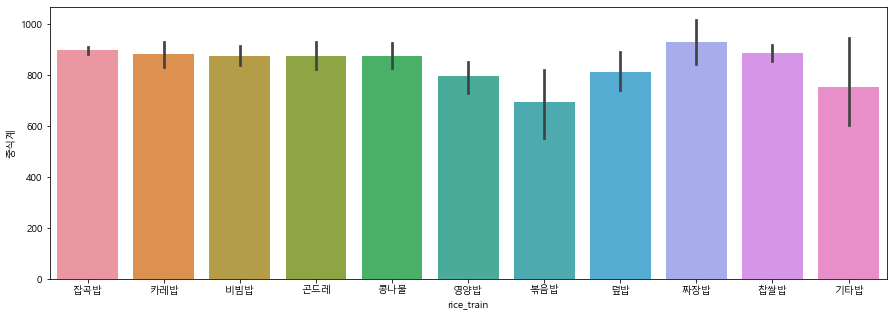

In [333]:
plt.figure(figsize=(15, 5))
sns.barplot(x="rice_train", y="중식계", data=lunch_food_eda)
plt.show()

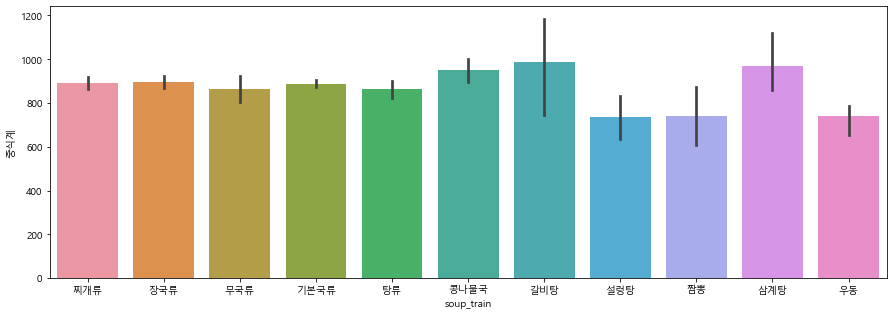

In [332]:
plt.figure(figsize=(15, 5))
sns.barplot(x="soup_train", y="중식계", data=lunch_food_eda)
plt.show()

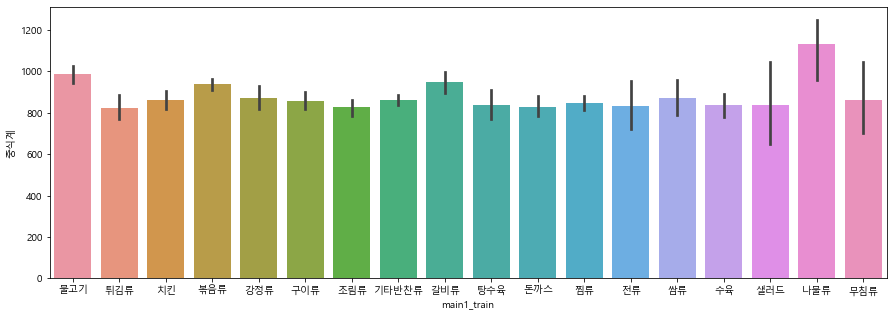

In [331]:
plt.figure(figsize=(15, 5))
sns.barplot(x="main1_train", y="중식계", data=lunch_food_eda)
plt.show()

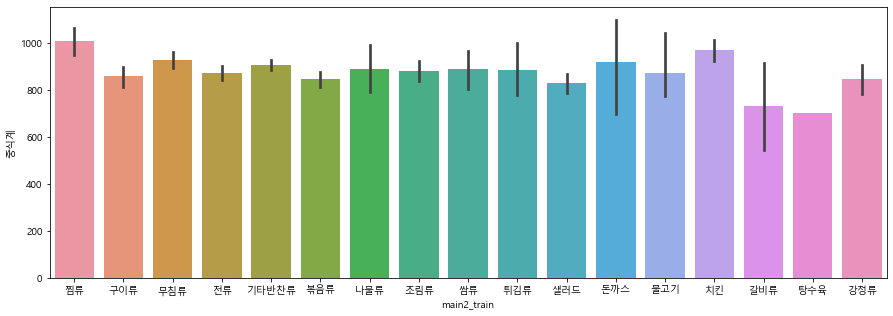

In [334]:
plt.figure(figsize=(15, 5))
sns.barplot(x="main2_train", y="중식계", data=lunch_food_eda)
plt.show()

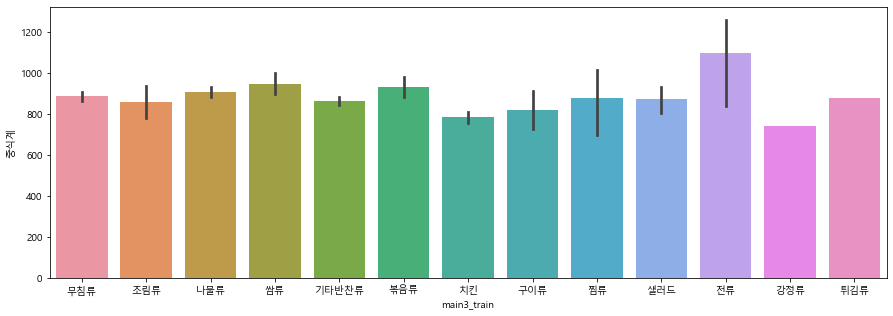

In [335]:
plt.figure(figsize=(15, 5))
sns.barplot(x="main3_train", y="중식계", data=lunch_food_eda)
plt.show()

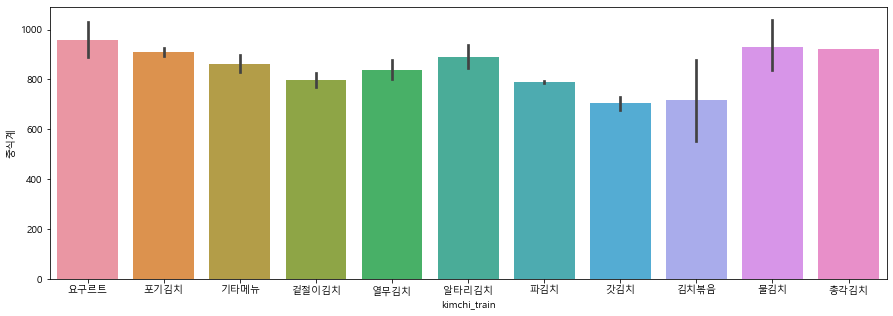

In [336]:
plt.figure(figsize=(15, 5))
sns.barplot(x="kimchi_train", y="중식계", data=lunch_food_eda)
plt.show()

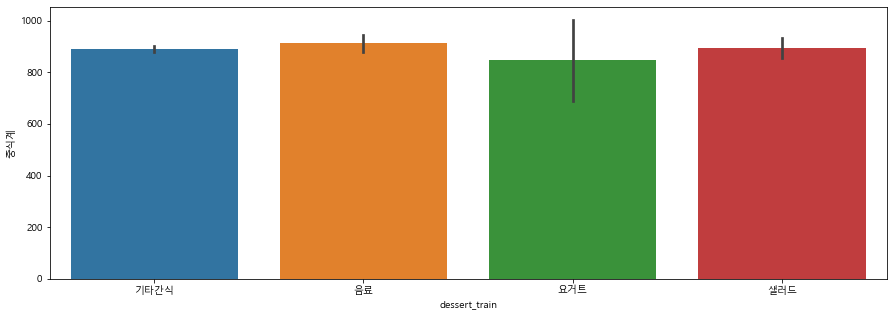

In [337]:
plt.figure(figsize=(15, 5))
sns.barplot(x="dessert_train", y="중식계", data=lunch_food_eda)
plt.show()

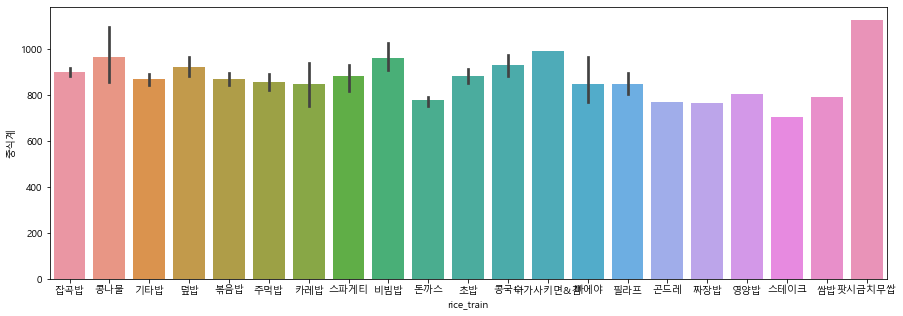

In [338]:
plt.figure(figsize=(15, 5))
sns.barplot(x="rice_train", y="중식계", data=dinner_food_eda)
plt.show()

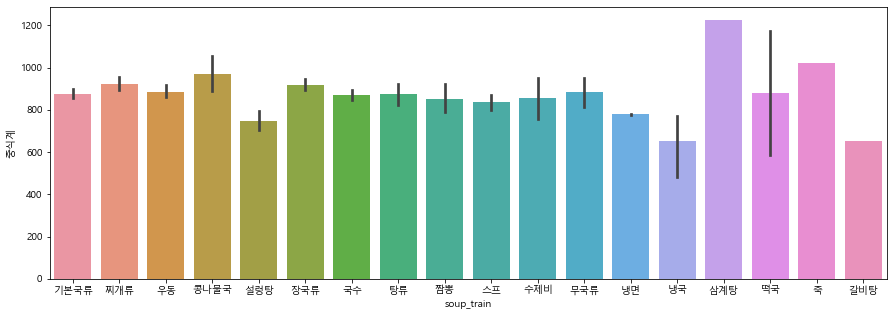

In [339]:
plt.figure(figsize=(15, 5))
sns.barplot(x="soup_train", y="중식계", data=dinner_food_eda)
plt.show()

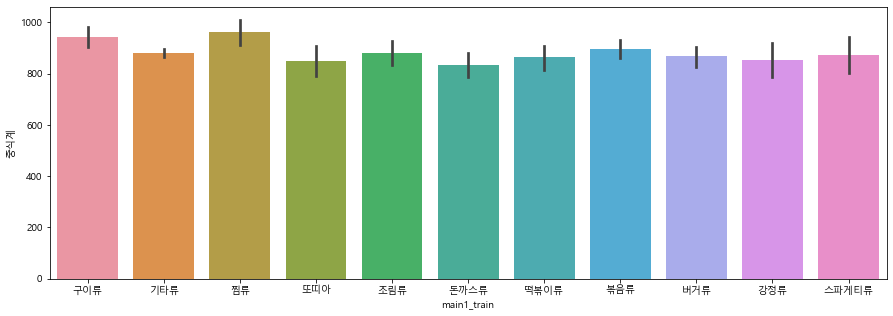

In [340]:
plt.figure(figsize=(15, 5))
sns.barplot(x="main1_train", y="중식계", data=dinner_food_eda)
plt.show()

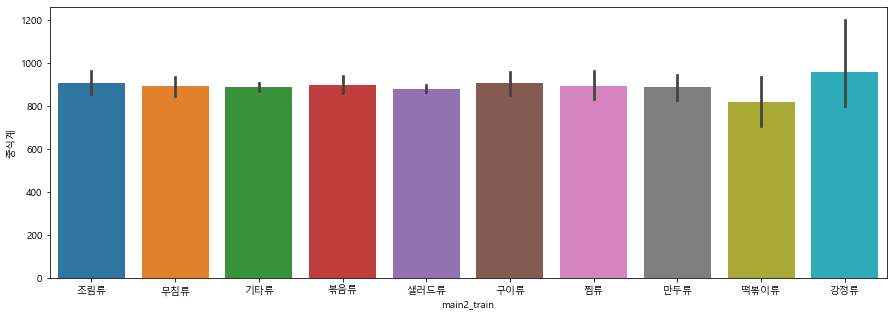

In [341]:
plt.figure(figsize=(15, 5))
sns.barplot(x="main2_train", y="중식계", data=dinner_food_eda)
plt.show()

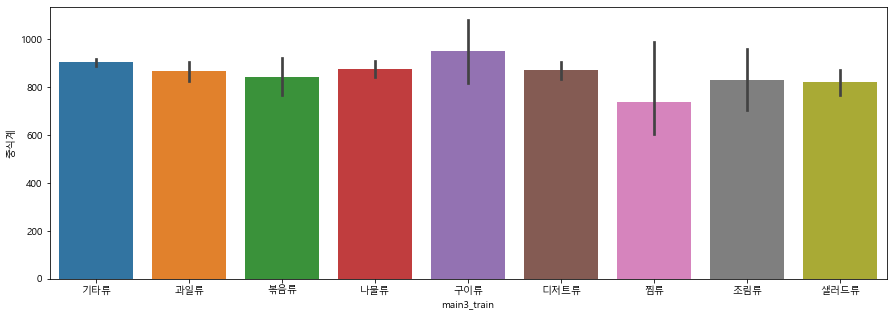

In [342]:
plt.figure(figsize=(15, 5))
sns.barplot(x="main3_train", y="중식계", data=dinner_food_eda)
plt.show()

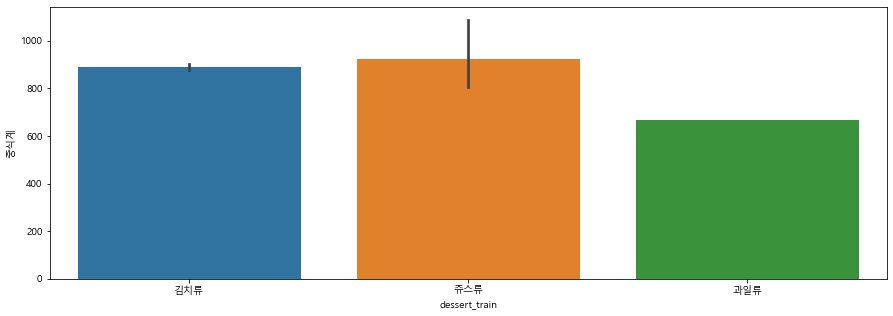

In [343]:
plt.figure(figsize=(15, 5))
sns.barplot(x="dessert_train", y="중식계", data=dinner_food_eda)
plt.show()

In [212]:
def lunch_label_train(x) :
    col_list = list(new_lunch_train[x])
    en = LabelEncoder()
    en.fit(new_lunch_train[x])
    x_list = en.transform(new_lunch_train[x])
    
    return x_list

def lunch_label_test(x) :
    col_list = list(new_lunch_test[x])
    en = LabelEncoder()
    en.fit(new_lunch_test[x])
    x_list = en.transform(new_lunch_test[x])
    
    return x_list
    
def dinner_label_train(x) :
    col_list = list(new_dinner_train[x])
    en = LabelEncoder()
    en.fit(new_dinner_train[x])
    x_list = en.transform(new_dinner_train[x])
    
    return x_list

def dinner_label_test(x) :
    col_list = list(new_dinner_test[x])
    en = LabelEncoder()
    en.fit(new_dinner_test[x])
    x_list = en.transform(new_dinner_test[x])
    
    return x_list

In [213]:
lunch_rice_train = lunch_label_train("rice_train")
lunch_soup_train = lunch_label_train("soup_train")
lunch_main1_train = lunch_label_train("main1_train")
lunch_main2_train = lunch_label_train("main2_train")
lunch_main3_train = lunch_label_train("main3_train")
lunch_kimchi_train = lunch_label_train("kimchi_train")
lunch_dessert_train = lunch_label_train("dessert_train")

lunch_rice_test = lunch_label_test("rice_test")
lunch_soup_test = lunch_label_test("soup_test")
lunch_main1_test = lunch_label_test("main1_test")
lunch_main2_test = lunch_label_test("main2_test")
lunch_main3_test = lunch_label_test("main3_test")
lunch_kimchi_test = lunch_label_test("kimchi_test")
lunch_dessert_test = lunch_label_test("dessert_test")

dinner_rice_train = dinner_label_train("rice_train")
dinner_soup_train = dinner_label_train("soup_train")
dinner_main1_train = dinner_label_train("main1_train")
dinner_main2_train = dinner_label_train("main2_train")
dinner_main3_train = dinner_label_train("main3_train")
dinner_dessert_train = dinner_label_train("dessert_train")

dinner_rice_test = dinner_label_test("rice_test")
dinner_soup_test = dinner_label_test("soup_test")
dinner_main1_test = dinner_label_test("main1_test")
dinner_main2_test = dinner_label_test("main2_test")
dinner_main3_test = dinner_label_test("main3_test")
dinner_dessert_test = dinner_label_test("dessert_test")

In [214]:
lunch_train_label = pd.DataFrame(data = list(zip(lunch_rice_train,lunch_soup_train,lunch_main1_train,lunch_main2_train,
                                          lunch_main3_train,lunch_kimchi_train,lunch_dessert_train, lunch_rice_train_cnt)),
                                columns=["밥", "국", "반찬1", "반찬2", "반찬3", "김치", "후식", "밥종류"])
lunch_test_label = pd.DataFrame(data = list(zip(lunch_rice_test,lunch_soup_test,lunch_main1_test,lunch_main2_test,
                                          lunch_main3_test,lunch_kimchi_test,lunch_dessert_test, lunch_rice_test_cnt)),
                                columns=["밥", "국", "반찬1", "반찬2", "반찬3", "김치", "후식", "밥종류"])

dinner_train_label = pd.DataFrame(data = list(zip(dinner_rice_train, dinner_soup_train,dinner_main1_train,dinner_main2_train,
                                          dinner_main3_train,dinner_dessert_train, dinner_rice_train_cnt)),
                                columns=["밥", "국", "반찬1", "반찬2", "반찬3", "후식", "밥종류"])
dinner_test_label = pd.DataFrame(data = list(zip(dinner_rice_test, dinner_soup_test,dinner_main1_test,dinner_main2_test,
                                          dinner_main3_test,dinner_dessert_test, dinner_rice_test_cnt)),
                                columns=["밥", "국", "반찬1", "반찬2", "반찬3", "후식", "밥종류"])

In [215]:
real_lunch_train = pd.concat([train, lunch_train_label], axis=1)
real_lunch_test = pd.concat([test, lunch_test_label], axis=1)
real_dinner_train = pd.concat([train, dinner_train_label], axis=1)
real_dinner_test = pd.concat([test, dinner_test_label], axis=1)

In [216]:
real_lunch_train.drop(["조식메뉴", "중식메뉴", "석식메뉴"], axis=1, inplace = True)
real_lunch_test.drop(["조식메뉴", "중식메뉴", "석식메뉴"], axis=1, inplace = True)
real_dinner_train.drop(["조식메뉴", "중식메뉴", "석식메뉴"], axis=1, inplace = True)
real_dinner_test.drop(["조식메뉴", "중식메뉴", "석식메뉴"], axis=1, inplace = True)

In [217]:
real_lunch_train.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,년,...,일,식사가능인원,밥,국,반찬1,반찬2,반찬3,김치,후식,밥종류
0,2016-02-01,0,2601,50,150,238,0.0,1039.0,331.0,2016,...,1,2551.0,6,8,8,13,4,7,0,2


In [221]:
real_lunch_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   int64  
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   중식계             1205 non-null   float64
 8   석식계             1205 non-null   float64
 9   년               1205 non-null   int64  
 10  월               1205 non-null   int64  
 11  일               1205 non-null   int64  
 12  식사가능인원          1205 non-null   float64
 13  밥               1205 non-null   int32  
 14  국               1205 non-null   int32  
 15  반찬1             1205 non-null   int32  
 16  반찬2             1205 non-null   int32  
 17  반찬3             1205 non-null   i

In [228]:
lunch_m = real_lunch_train.groupby("일").mean()[["밥", "국", "반찬1", "반찬2", "반찬3", "김치", "후식", "밥종류"]]

In [225]:
lunch_m

,밥,국,반찬1,반찬2,반찬3,김치,후식,밥종류
요일,,,,,,,,
0,5.983402,4.850622,6.626556,7.261411,3.941909,9.319502,0.116183,2.103734
1,5.958333,4.954167,7.466667,6.783333,3.779167,7.712500,0.137500,2.075000
2,5.368201,4.301255,7.305439,6.694561,3.552301,7.548117,0.121339,1.443515
3,5.975410,4.094262,8.159836,7.016393,3.467213,7.360656,0.127049,2.073770
4,5.742739,4.721992,8.107884,7.290456,3.452282,7.195021,0.116183,1.950207


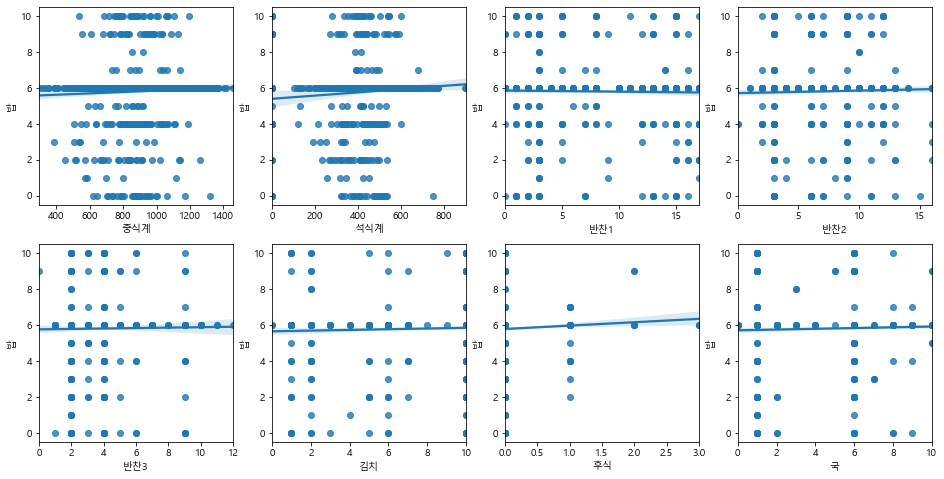

In [233]:
fig, axs = plt.subplots(figsize = (16,8), ncols = 4, nrows = 2)
food = ["중식계", "석식계", "반찬1", "반찬2", "반찬3", "김치", "후식", "국"]
for i, feature in enumerate(food):
    row = int(i/4)
    col = i%4
    sns.regplot(x=feature, y="밥", data=real_lunch_train , ax=axs[row][col])

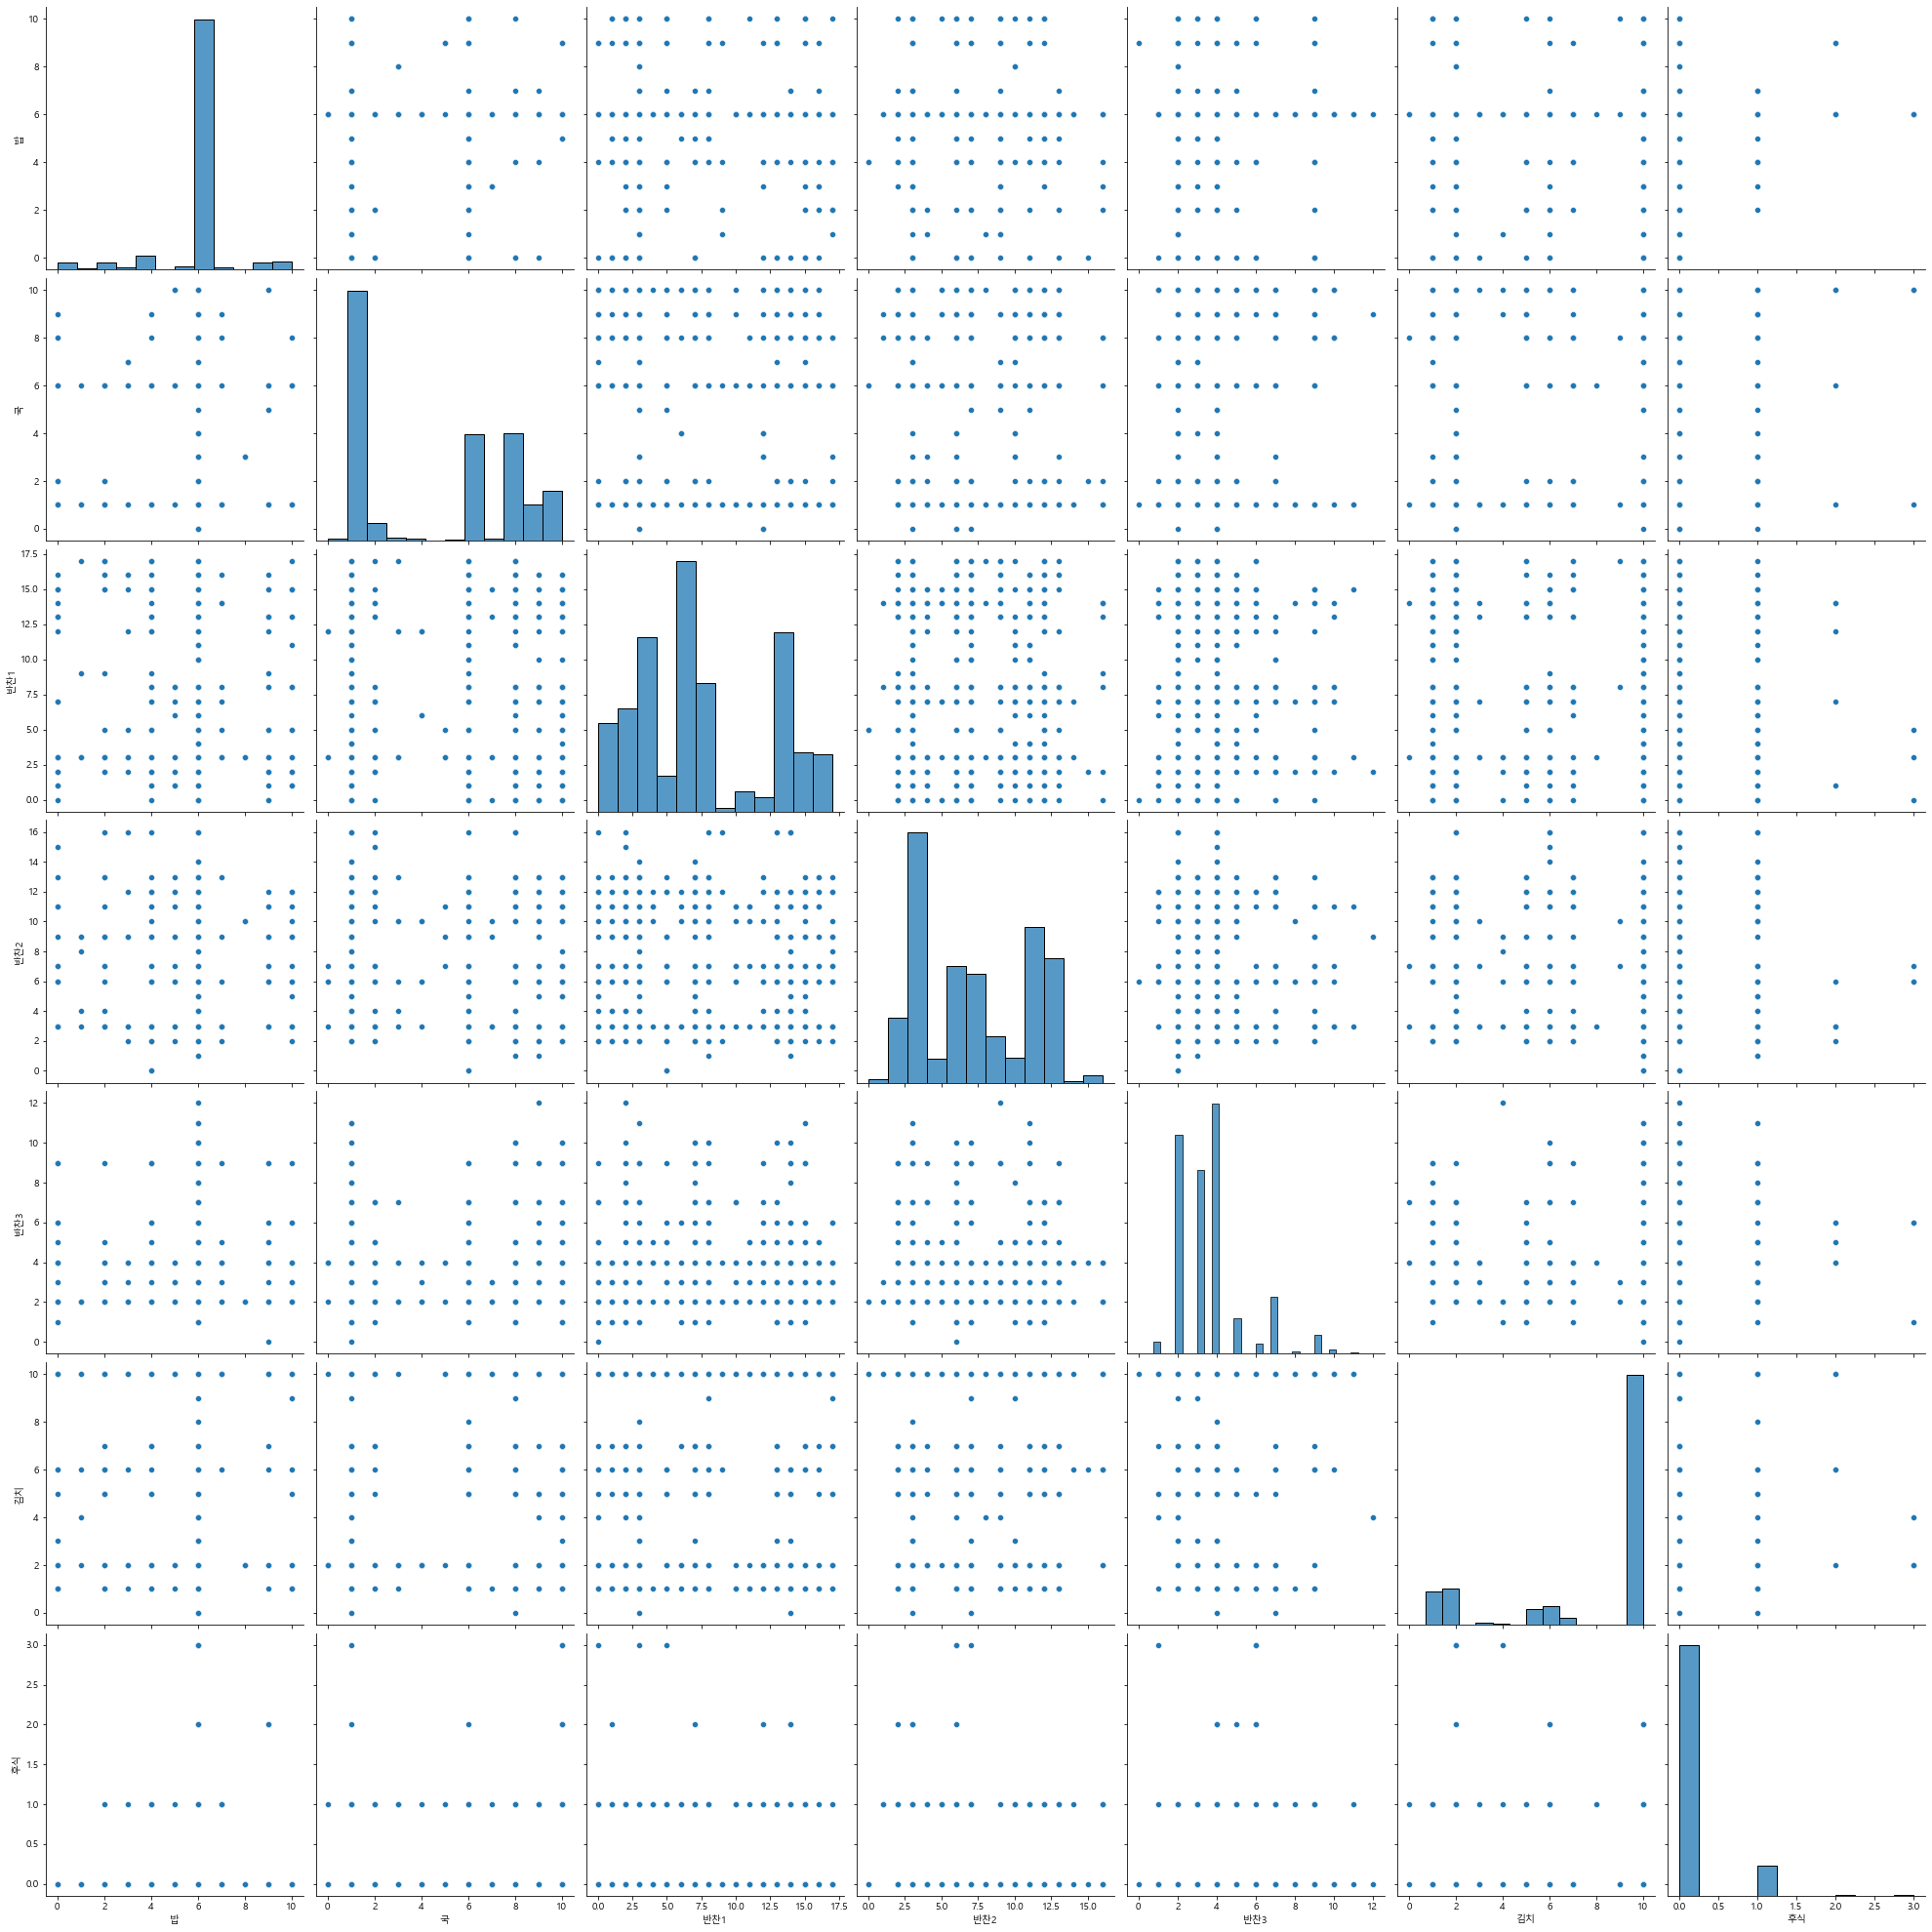

In [230]:
sns.pairplot(real_lunch_train[["밥", "국", "반찬1", "반찬2", "반찬3", "김치", "후식"]], height=4)

KeyboardInterrupt: 

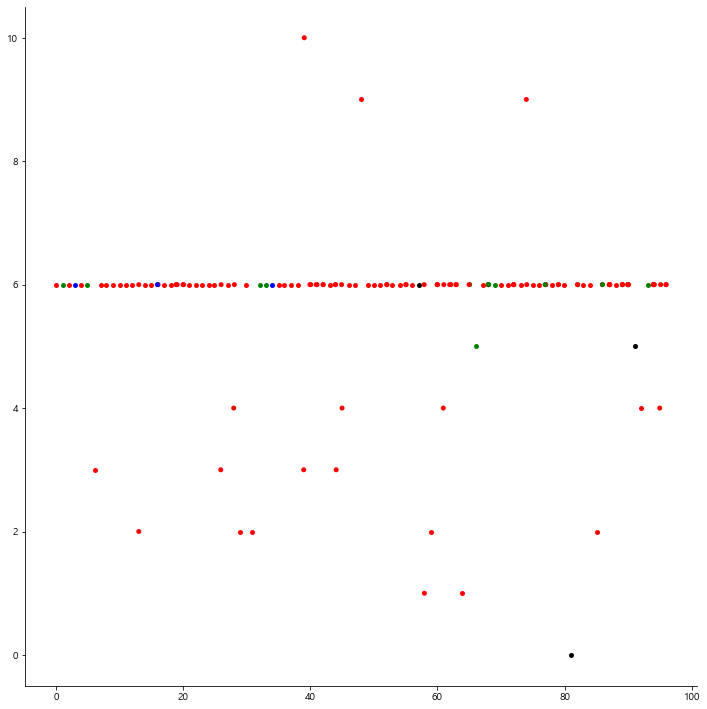

In [232]:
sns.catplot(x='중식계', y='밥', hue='요일', data=real_lunch_train, height=10, palette = sns.color_palette(['red', 'blue', 'black', 'green',]))

In [140]:
x1_train = real_lunch_train.drop(["일자", "중식계", "석식계", "본사시간외근무명령서승인건수"], axis=1, inplace = False)
x2_train = real_dinner_train.drop(["일자", "중식계", "석식계"], axis=1, inplace = False)
y1_train = train['중식계']
y2_train = train['석식계']

x1_test = real_lunch_test.drop(["일자", "본사시간외근무명령서승인건수"], axis=1, inplace = False)
x2_test = real_dinner_test.drop(["일자"], axis=1, inplace = False)

In [141]:
model1 = CatBoostRegressor()
model2 = CatBoostRegressor()

model1.fit(x1_train, y1_train)
model2.fit(x2_train, y2_train)

pred1 = model1.predict(x1_test)
pred2 = model2.predict(x2_test)

Learning rate set to 0.040347
0:	learn: 202.4669750	total: 153ms	remaining: 2m 32s
1:	learn: 196.0763969	total: 156ms	remaining: 1m 17s
2:	learn: 190.0807366	total: 158ms	remaining: 52.6s
3:	learn: 184.1772757	total: 161ms	remaining: 40.1s
4:	learn: 178.7143077	total: 163ms	remaining: 32.5s
5:	learn: 173.5090638	total: 166ms	remaining: 27.5s
6:	learn: 167.9420753	total: 168ms	remaining: 23.8s
7:	learn: 162.9732095	total: 169ms	remaining: 21s
8:	learn: 158.3634331	total: 171ms	remaining: 18.8s
9:	learn: 153.6615774	total: 172ms	remaining: 17.1s
10:	learn: 149.4353455	total: 174ms	remaining: 15.6s
11:	learn: 144.9863717	total: 175ms	remaining: 14.4s
12:	learn: 140.4524862	total: 177ms	remaining: 13.4s
13:	learn: 136.5097949	total: 179ms	remaining: 12.6s
14:	learn: 132.6325782	total: 180ms	remaining: 11.8s
15:	learn: 128.6480435	total: 182ms	remaining: 11.2s
16:	learn: 124.7650149	total: 183ms	remaining: 10.6s
17:	learn: 121.3503495	total: 185ms	remaining: 10.1s
18:	learn: 117.6110788	tot

237:	learn: 9.8829310	total: 503ms	remaining: 1.61s
238:	learn: 9.8254957	total: 504ms	remaining: 1.61s
239:	learn: 9.8051020	total: 506ms	remaining: 1.6s
240:	learn: 9.7872814	total: 507ms	remaining: 1.6s
241:	learn: 9.7715515	total: 509ms	remaining: 1.59s
242:	learn: 9.7218492	total: 510ms	remaining: 1.59s
243:	learn: 9.6790511	total: 512ms	remaining: 1.59s
244:	learn: 9.6603398	total: 513ms	remaining: 1.58s
245:	learn: 9.6034945	total: 515ms	remaining: 1.58s
246:	learn: 9.5877901	total: 517ms	remaining: 1.57s
247:	learn: 9.5729690	total: 518ms	remaining: 1.57s
248:	learn: 9.5259832	total: 519ms	remaining: 1.57s
249:	learn: 9.4821155	total: 521ms	remaining: 1.56s
250:	learn: 9.4360858	total: 523ms	remaining: 1.56s
251:	learn: 9.4055252	total: 524ms	remaining: 1.55s
252:	learn: 9.3518511	total: 526ms	remaining: 1.55s
253:	learn: 9.3204819	total: 528ms	remaining: 1.55s
254:	learn: 9.2907994	total: 529ms	remaining: 1.55s
255:	learn: 9.2440964	total: 531ms	remaining: 1.54s
256:	learn: 9.

464:	learn: 5.1695815	total: 820ms	remaining: 943ms
465:	learn: 5.1602594	total: 821ms	remaining: 941ms
466:	learn: 5.1486622	total: 823ms	remaining: 939ms
467:	learn: 5.1357600	total: 824ms	remaining: 937ms
468:	learn: 5.1226390	total: 825ms	remaining: 935ms
469:	learn: 5.1108306	total: 827ms	remaining: 933ms
470:	learn: 5.1015264	total: 829ms	remaining: 931ms
471:	learn: 5.0945251	total: 830ms	remaining: 929ms
472:	learn: 5.0829914	total: 832ms	remaining: 927ms
473:	learn: 5.0708860	total: 833ms	remaining: 925ms
474:	learn: 5.0555342	total: 835ms	remaining: 923ms
475:	learn: 5.0441169	total: 836ms	remaining: 920ms
476:	learn: 5.0325662	total: 838ms	remaining: 918ms
477:	learn: 5.0228975	total: 839ms	remaining: 916ms
478:	learn: 5.0103974	total: 841ms	remaining: 915ms
479:	learn: 4.9997671	total: 843ms	remaining: 913ms
480:	learn: 4.9913663	total: 845ms	remaining: 912ms
481:	learn: 4.9788823	total: 847ms	remaining: 910ms
482:	learn: 4.9759836	total: 848ms	remaining: 908ms
483:	learn: 

690:	learn: 3.5741587	total: 1.14s	remaining: 511ms
691:	learn: 3.5676561	total: 1.15s	remaining: 510ms
692:	learn: 3.5630263	total: 1.15s	remaining: 508ms
693:	learn: 3.5618881	total: 1.15s	remaining: 506ms
694:	learn: 3.5546766	total: 1.15s	remaining: 505ms
695:	learn: 3.5509271	total: 1.15s	remaining: 503ms
696:	learn: 3.5467271	total: 1.15s	remaining: 501ms
697:	learn: 3.5427309	total: 1.15s	remaining: 499ms
698:	learn: 3.5368906	total: 1.16s	remaining: 498ms
699:	learn: 3.5321022	total: 1.16s	remaining: 496ms
700:	learn: 3.5254903	total: 1.16s	remaining: 494ms
701:	learn: 3.5212321	total: 1.16s	remaining: 492ms
702:	learn: 3.5182606	total: 1.16s	remaining: 491ms
703:	learn: 3.5141360	total: 1.16s	remaining: 489ms
704:	learn: 3.5080649	total: 1.16s	remaining: 487ms
705:	learn: 3.5010919	total: 1.17s	remaining: 486ms
706:	learn: 3.4961668	total: 1.17s	remaining: 484ms
707:	learn: 3.4913950	total: 1.17s	remaining: 482ms
708:	learn: 3.4850518	total: 1.17s	remaining: 480ms
709:	learn: 

929:	learn: 2.6481134	total: 1.47s	remaining: 111ms
930:	learn: 2.6443846	total: 1.47s	remaining: 109ms
931:	learn: 2.6420255	total: 1.47s	remaining: 108ms
932:	learn: 2.6363668	total: 1.48s	remaining: 106ms
933:	learn: 2.6337939	total: 1.48s	remaining: 104ms
934:	learn: 2.6315483	total: 1.48s	remaining: 103ms
935:	learn: 2.6306840	total: 1.48s	remaining: 101ms
936:	learn: 2.6287800	total: 1.48s	remaining: 99.6ms
937:	learn: 2.6279617	total: 1.48s	remaining: 98ms
938:	learn: 2.6238118	total: 1.48s	remaining: 96.4ms
939:	learn: 2.6203574	total: 1.49s	remaining: 94.8ms
940:	learn: 2.6157771	total: 1.49s	remaining: 93.2ms
941:	learn: 2.6125296	total: 1.49s	remaining: 91.7ms
942:	learn: 2.6086451	total: 1.49s	remaining: 90.1ms
943:	learn: 2.6079693	total: 1.49s	remaining: 88.5ms
944:	learn: 2.6047320	total: 1.49s	remaining: 86.9ms
945:	learn: 2.6032440	total: 1.49s	remaining: 85.3ms
946:	learn: 2.6003878	total: 1.5s	remaining: 83.7ms
947:	learn: 2.5970777	total: 1.5s	remaining: 82.1ms
948:

109:	learn: 13.3194699	total: 167ms	remaining: 1.35s
110:	learn: 13.2050452	total: 169ms	remaining: 1.35s
111:	learn: 13.0699351	total: 170ms	remaining: 1.35s
112:	learn: 12.9372463	total: 172ms	remaining: 1.35s
113:	learn: 12.7890714	total: 173ms	remaining: 1.34s
114:	learn: 12.6798742	total: 174ms	remaining: 1.34s
115:	learn: 12.5553627	total: 176ms	remaining: 1.34s
116:	learn: 12.4730313	total: 177ms	remaining: 1.34s
117:	learn: 12.3584815	total: 179ms	remaining: 1.34s
118:	learn: 12.2368229	total: 180ms	remaining: 1.33s
119:	learn: 12.1578498	total: 182ms	remaining: 1.33s
120:	learn: 12.0558238	total: 183ms	remaining: 1.33s
121:	learn: 11.9508617	total: 185ms	remaining: 1.33s
122:	learn: 11.8267712	total: 187ms	remaining: 1.33s
123:	learn: 11.7398661	total: 189ms	remaining: 1.33s
124:	learn: 11.6374638	total: 190ms	remaining: 1.33s
125:	learn: 11.5198380	total: 191ms	remaining: 1.33s
126:	learn: 11.4076698	total: 193ms	remaining: 1.33s
127:	learn: 11.3040184	total: 194ms	remaining:

339:	learn: 4.5235523	total: 489ms	remaining: 950ms
340:	learn: 4.5062903	total: 491ms	remaining: 949ms
341:	learn: 4.4901586	total: 493ms	remaining: 948ms
342:	learn: 4.4810579	total: 494ms	remaining: 946ms
343:	learn: 4.4664059	total: 496ms	remaining: 945ms
344:	learn: 4.4581723	total: 497ms	remaining: 944ms
345:	learn: 4.4439952	total: 499ms	remaining: 943ms
346:	learn: 4.4306368	total: 500ms	remaining: 941ms
347:	learn: 4.4155063	total: 502ms	remaining: 940ms
348:	learn: 4.4041544	total: 503ms	remaining: 939ms
349:	learn: 4.3909951	total: 505ms	remaining: 937ms
350:	learn: 4.3749052	total: 506ms	remaining: 936ms
351:	learn: 4.3611363	total: 508ms	remaining: 935ms
352:	learn: 4.3494372	total: 509ms	remaining: 934ms
353:	learn: 4.3326530	total: 511ms	remaining: 933ms
354:	learn: 4.3163057	total: 513ms	remaining: 932ms
355:	learn: 4.2983000	total: 514ms	remaining: 930ms
356:	learn: 4.2883891	total: 516ms	remaining: 929ms
357:	learn: 4.2767033	total: 517ms	remaining: 927ms
358:	learn: 

561:	learn: 2.7474620	total: 815ms	remaining: 635ms
562:	learn: 2.7439198	total: 816ms	remaining: 633ms
563:	learn: 2.7383284	total: 818ms	remaining: 632ms
564:	learn: 2.7345760	total: 819ms	remaining: 630ms
565:	learn: 2.7286035	total: 820ms	remaining: 629ms
566:	learn: 2.7203574	total: 822ms	remaining: 628ms
567:	learn: 2.7144433	total: 823ms	remaining: 626ms
568:	learn: 2.7106514	total: 825ms	remaining: 625ms
569:	learn: 2.7080407	total: 826ms	remaining: 623ms
570:	learn: 2.7035998	total: 828ms	remaining: 622ms
571:	learn: 2.7005652	total: 830ms	remaining: 621ms
572:	learn: 2.6945940	total: 831ms	remaining: 619ms
573:	learn: 2.6907062	total: 832ms	remaining: 618ms
574:	learn: 2.6852576	total: 834ms	remaining: 617ms
575:	learn: 2.6787092	total: 836ms	remaining: 615ms
576:	learn: 2.6732804	total: 838ms	remaining: 614ms
577:	learn: 2.6693961	total: 839ms	remaining: 612ms
578:	learn: 2.6634820	total: 840ms	remaining: 611ms
579:	learn: 2.6599571	total: 842ms	remaining: 610ms
580:	learn: 

783:	learn: 1.9474842	total: 1.14s	remaining: 313ms
784:	learn: 1.9461384	total: 1.14s	remaining: 312ms
785:	learn: 1.9436570	total: 1.14s	remaining: 310ms
786:	learn: 1.9407605	total: 1.14s	remaining: 309ms
787:	learn: 1.9386831	total: 1.14s	remaining: 307ms
788:	learn: 1.9351818	total: 1.14s	remaining: 306ms
789:	learn: 1.9326623	total: 1.15s	remaining: 305ms
790:	learn: 1.9316019	total: 1.15s	remaining: 303ms
791:	learn: 1.9287272	total: 1.15s	remaining: 302ms
792:	learn: 1.9268099	total: 1.15s	remaining: 300ms
793:	learn: 1.9241376	total: 1.15s	remaining: 299ms
794:	learn: 1.9218756	total: 1.15s	remaining: 298ms
795:	learn: 1.9187921	total: 1.16s	remaining: 296ms
796:	learn: 1.9156434	total: 1.16s	remaining: 295ms
797:	learn: 1.9135365	total: 1.16s	remaining: 293ms
798:	learn: 1.9112909	total: 1.16s	remaining: 292ms
799:	learn: 1.9085270	total: 1.16s	remaining: 291ms
800:	learn: 1.9069550	total: 1.16s	remaining: 289ms
801:	learn: 1.9060607	total: 1.17s	remaining: 288ms
802:	learn: 

992:	learn: 1.5052999	total: 1.46s	remaining: 10.3ms
993:	learn: 1.5035678	total: 1.46s	remaining: 8.81ms
994:	learn: 1.5018743	total: 1.46s	remaining: 7.35ms
995:	learn: 1.4998067	total: 1.46s	remaining: 5.88ms
996:	learn: 1.4988340	total: 1.47s	remaining: 4.41ms
997:	learn: 1.4970866	total: 1.47s	remaining: 2.94ms
998:	learn: 1.4944792	total: 1.47s	remaining: 1.47ms
999:	learn: 1.4927877	total: 1.47s	remaining: 0us


CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 5 should be feature with name 년 (found 월).

In [ ]:
vot1 = VotingRegressor(estimators=[('gb', GB), ('rf', RF), ('lr', LR), ('cb', CB), ('abr', ABR),
                                   ('br', BR), ('etr', ETR), ('xgbr', XGBR)])
vot2 = VotingRegressor(estimators=[('gb', GB), ('rf', RF), ('lr', LR), ('cb', CB), ('abr', ABR),
                                   ('br', BR), ('etr', ETR), ('xgbr', XGBR)])

vot1.fit(x1_train, y1_train)
vot2.fit(x2_train, y2_train)

pred1 = vot1.predict(x1_test)
pred2 = vot2.predict(x2_test)